In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
from nanonets import Simulation
from scipy.optimize import curve_fit
plt.style.use(["science","bright","grid"])

/home/jonasmensing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def get_linear_volt_ranges(n, ref_electrodes=[1,3], I_ref=1e-9, alpha=0.3):
    
    topo = {"Nx": n, "Ny": n,
            "e_pos" : [[0,0], [int((n-1)/2),0], [n-1,0], [0,int((n-1)/2)],
                       [0,n-1], [n-1,int((n)/2)], [int((n)/2),(n-1)], [n-1,n-1]],
            "electrode_type" : ['constant']*8}
    sim_class = Simulation(topology_parameter=topo)
    sim_class.build_conductance_matrix()
    sim_class.init_transfer_coeffs()
    sim_class.calibrate_electrodes(ref_electrodes, I_ref, alpha)

    return sim_class.get_delta_V()

def get_linear_voltage_sweep(n, e, Vmin=0, Vmax=1, N_data=100):
    
    topo = {"Nx": n, "Ny": n,
            "e_pos" : [[0,0], [int((n-1)/2),0], [n-1,0], [0,int((n-1)/2)],
                       [0,n-1], [n-1,int((n)/2)], [int((n)/2),(n-1)], [n-1,n-1]],
            "electrode_type" : ['constant']*8}
    sim_class = Simulation(topology_parameter=topo)
    sim_class.build_conductance_matrix()
    sim_class.init_transfer_coeffs()

    G           = sim_class.get_transfer_coeffs()
    I_lin       = []
    V_vals      = np.zeros((N_data,len(topo["e_pos"])))
    V_vals[:,e] = np.linspace(Vmin, Vmax, N_data)
    I_lin       = np.dot(V_vals, G)

    return I_lin

### Comparison of nonlinear currents at low and high temperature with linear limit

In [ ]:
path        = "/mnt/c/Users/jonas/Desktop/phd/data/1_funding_period/electrode_impact/voltage_sweep/"
N_vals      = np.arange(3,17)
data        = {n : {i : pd.read_csv(f"{path}Nx={n}_Ny={n}_Ne=8_{i}.csv").loc[:,[f'E{i}','Observable','Error']] for i in [0,1,2,5]} for n in N_vals}
data_room   = {n : {i : pd.read_csv(f"{path}Nx={n}_Ny={n}_Ne=8_{i}_T_300.csv").loc[:,[f'E{i}','Observable','Error']] for i in [0,1,2,5]} for n in N_vals[:9]}
data_lin    = {n : {i : get_linear_voltage_sweep(n,i) for i in [0,1,2,5]} for n in N_vals}

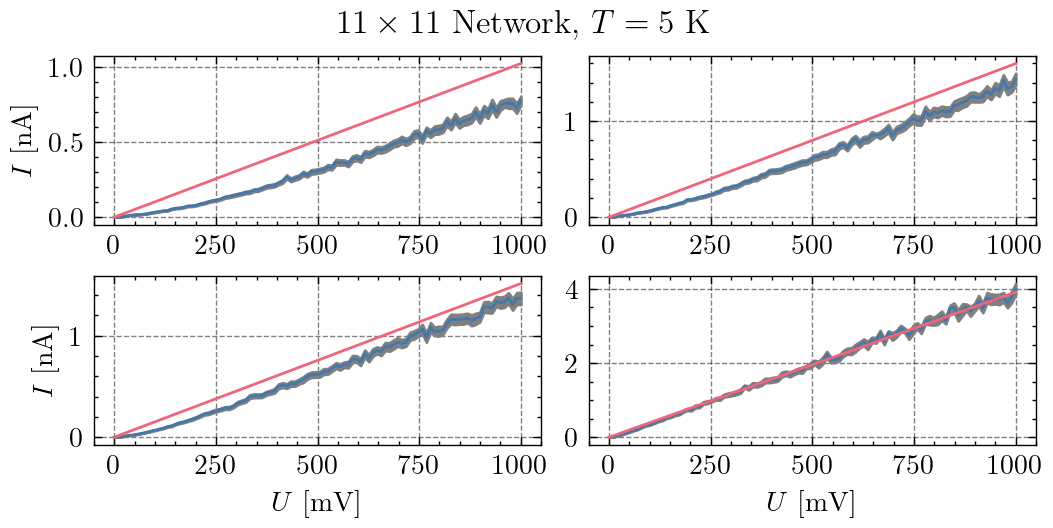

In [ ]:
n   = 11
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.suptitle(f"${n}\\times{n}$ Network, $T = 5$ K")

for i, e in enumerate([0,1,2,5]):

    x   = data[n][e][f'E{e}'].values*1e3
    y   = data[n][e]['Observable'].values*1e-9
    y_l = data_lin[n][e]*1e9
    y_e = data[n][e]['Error'].values*1e-9

    ax = fig.add_subplot(2,2,i+1)
    ax.plot(x, y)
    ax.plot(x, y_l)
    ax.fill_between(x, y-y_e, y+y_e, color='grey')

    if i % 2 == 0:
        ax.set_ylabel("$I$ [nA]")
    if i >= 2:
        ax.set_xlabel("$U$ [mV]")

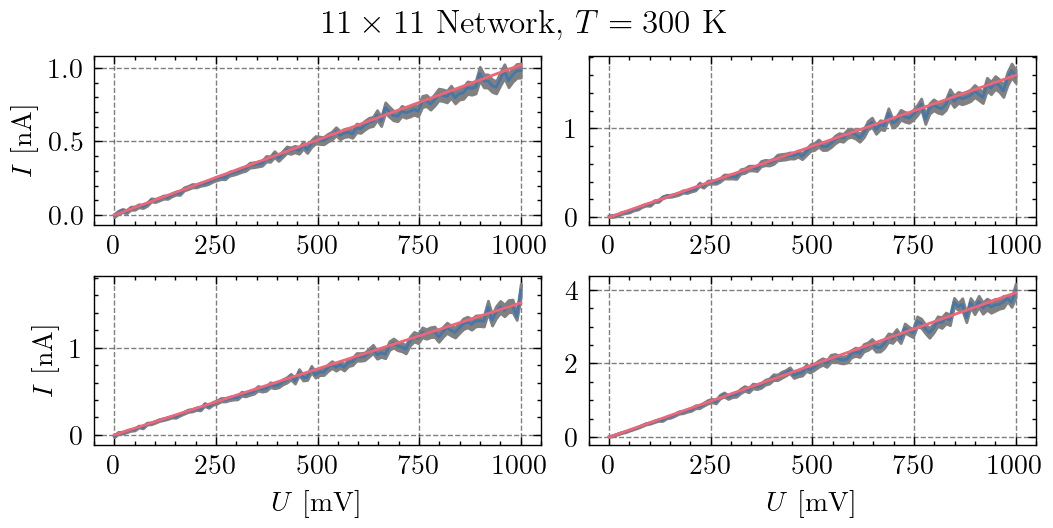

In [ ]:
n   = 11
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.suptitle(f"${n}\\times{n}$ Network, $T = 300$ K")

for i, e in enumerate([0,1,2,5]):

    x   = data_room[n][e][f'E{e}'].values*1e3
    y   = data_room[n][e]['Observable'].values*1e-9
    y_l = data_lin[n][e]*1e9
    y_e = data_room[n][e]['Error'].values*1e-9

    ax = fig.add_subplot(2,2,i+1)
    ax.plot(x, y)
    ax.plot(x, y_l)
    ax.fill_between(x, y-y_e, y+y_e, color='grey')

    if i % 2 == 0:
        ax.set_ylabel("$I$ [nA]")
    if i >= 2:
        ax.set_xlabel("$U$ [mV]")

### Electrode voltage ranges based on reference current driven by two input voltages

In [ ]:
alphas   = [0.3,0.5,0.8,1.0]
ref_idx  = [1,3]
delta_V  = {alpha: pd.DataFrame(np.array([get_linear_volt_ranges(N, ref_idx, alpha=alpha) for N in N_vals])) for alpha in alphas}

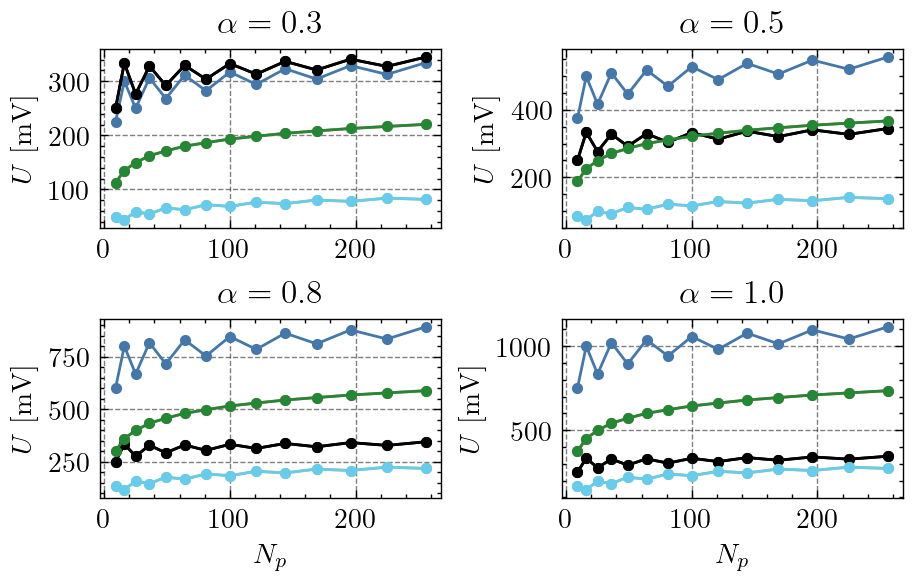

In [9]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.3)
fig.set_figheight(fig.get_figheight()*1.1)
for i, alpha in enumerate(alphas):
    ax = fig.add_subplot(2,2,i+1)
    for e in range(7):
        if e not in ref_idx:
            ax.plot(N_vals**2, delta_V[alpha][e]*1000, '.-')
        else:
            ax.plot(N_vals**2, delta_V[alpha][e]*1000, '.-', color='black')
    if i >= 2:
        ax.set_xlabel("$N_p$")
    ax.set_ylabel("$U$ [mV]")
    ax.set_title(f"$\\alpha = {alpha}$")

### Scale electrode voltage range based on transfer coefficients

In [31]:
def get_transfer_coeff(n):
    
    topo = {"Nx": n, "Ny": n,
            "e_pos" : [[0,0], [int((n-1)/2),0], [n-1,0], [0,int((n-1)/2)],
                       [0,n-1], [n-1,int((n)/2)], [int((n)/2),(n-1)], [n-1,n-1]],
            "electrode_type" : ['constant']*8}
    sim_class = Simulation(topology_parameter=topo)
    sim_class.build_conductance_matrix()
    sim_class.init_transfer_coeffs()

    return sim_class.get_transfer_coeffs()

transf_coeff                            = np.array([get_transfer_coeff(n) for n in N_vals])
voltage_adj                             = transf_coeff[7,1]/np.array(transf_coeff)
voltage_adj[voltage_adj==np.inf]        = 0
np.save(file="../voltage_range.npy", arr=voltage_adj)

/tmp/ipykernel_666/2566463449.py:14: RuntimeWarning: divide by zero encountered in divide
  voltage_adj                             = transf_coeff[7,1]/np.array(transf_coeff)


In [32]:
path        = "/mnt/c/Users/jonas/Desktop/phd/data/1_funding_period/electrode_impact/voltage_sweep/"
N_vals      = np.arange(3,17)
data_scaled = {n : {i : pd.read_csv(f"{path}Nx={n}_Ny={n}_Ne=8_{i}_scaled.csv").loc[:,[f'E{i}','Observable','Error']] for i in [0,1,2,5]} for n in N_vals}

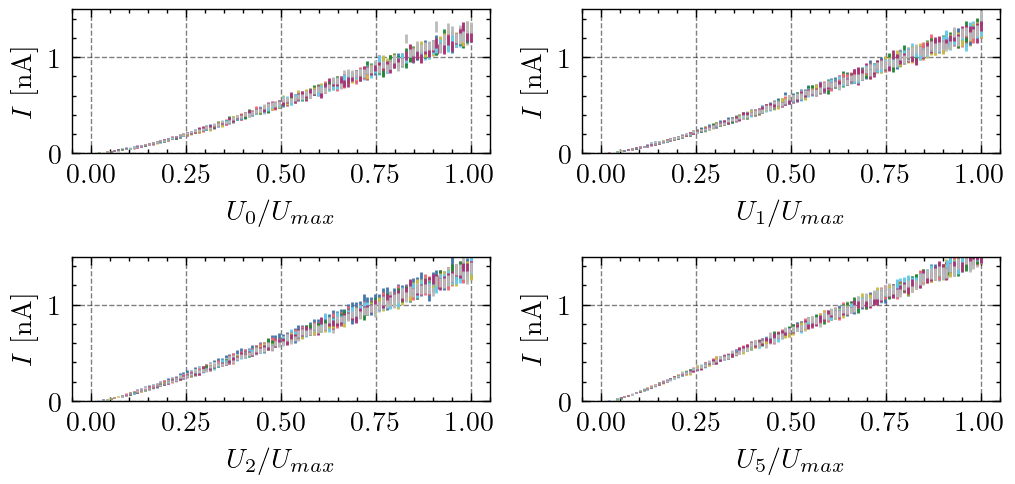

In [33]:
fig = plt.figure(dpi=200, layout='tight')
fig.set_figwidth(fig.get_figwidth()*1.5)
for i, e in enumerate([0,1,2,5]):
    ax  = fig.add_subplot(2,2,i+1)
    for n in N_vals:
        x   = data_scaled[n][e][f'E{e}'].values*1000
        y   = data_scaled[n][e]['Observable'].values*1e-9
        y_e = data_scaled[n][e]['Error'].values*1e-9
        ax.errorbar(x/np.max(x),y,y_e,ls='')
    ax.set_ylim(0,1.5)
    ax.set_xlabel(f"$U_{e}/"+"U_{max}$")
    ax.set_ylabel("$I$ [nA]")